# Compiler examples

## Reshape and reduce

B : [-0.4437089  -0.85547827  1.00354184 -0.64399302 -1.09157989  0.80370961
  0.63672228 -0.01870391  0.5310999  -0.36083616 -1.17629118  0.01338316
  2.16303901 -0.27894711 -1.36456854  0.55323565 -1.76227193 -1.82944774
  0.03002275 -0.27844572 -0.5236383  -0.42003632  0.65967596  0.27820339
 -1.64486467  1.31800617  0.71697246  0.12399182 -1.44015009 -0.28099886
  0.30566422 -0.46656331 -0.34989396 -0.59700666 -0.01482707  1.21382211
 -0.65002842  2.16335708 -1.04263035 -0.26676791 -0.46512439 -0.79338762
 -1.01487753  1.36948253 -2.00744343  1.0993987  -0.6240219   1.15666069
 -0.10254484  2.04861119  0.83521437  1.68657791 -0.03041608  0.58045749
 -0.70688407  1.95183991  0.27559022  0.46593642  1.80742399  0.16929807]
C : [[-0.4437089  -0.85547827  1.00354184 -0.64399302 -1.09157989  0.80370961
   0.63672228 -0.01870391  0.5310999  -0.36083616]
 [-1.17629118  0.01338316  2.16303901 -0.27894711 -1.36456854  0.55323565
  -1.76227193 -1.82944774  0.03002275 -0.27844572]
 [-0.523638

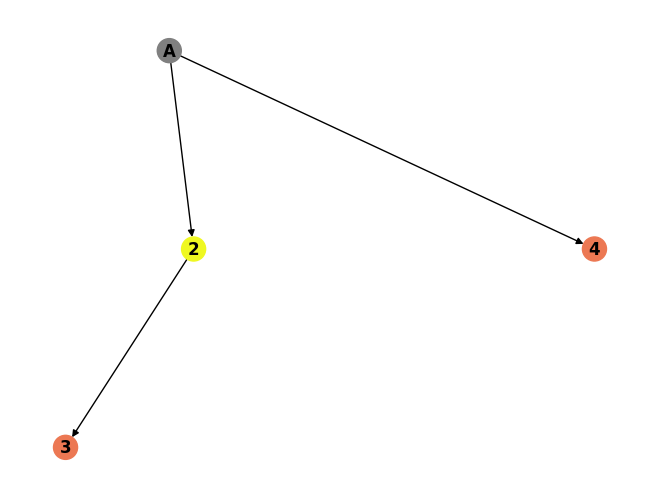

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.seterr(all="print")
import tensorcraft as tc

from tensorcraft.viz.program_graph import draw_program_graph, draw_expression_graph

join_and_split_axis_program = tc.compile("""
B[(ijk)] = A[i,j,k]
C[i,j] = B[(ij)]                                       
Row[j] = A[0,j,k]
""")

A = np.random.randn(3, 4, 5)
expected_B = A.reshape(60)
expected_C = expected_B.reshape(6, 10)
outputs = join_and_split_axis_program.execute(inputs={
    "A": A
}, shape_hints={
    "B": (60,),
    "C": (6,10),
    "Row": (4,)
})

print("B :", outputs["B"])
print("C :", outputs["C"])
print("Row :", outputs["Row"])

print("B ~= expected_B: ", np.allclose(outputs["B"], expected_B))
print("C ~= expected_C: ", np.allclose(outputs["C"], expected_C))

tc.viz.draw_program_graph(join_and_split_axis_program)

## Expressions with mutiple tensor orders

[Tree(Token('RULE', 'tensorop'), ['B[i,j]']), 'B[j,i]']
[Tree(Token('RULE', 'tensorop'), ['C[i]'])]
['+ 0', 'sin 0']
['+ 1', 'D[]']
['+ 2', Token('INDEXVAR', 'i')]
Positioning nodes


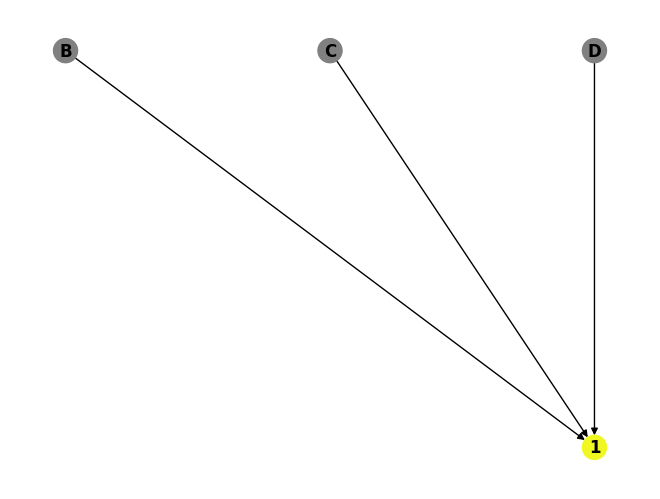

In [2]:
small_program = tc.compile("A[i,j] = B[i,j] + B[j,i] + sin(C[i]) + D + i")
# small_program = tc.compile("A[i,j] = sin(B[i,j] + C[i]) + D + i")
tc.viz.draw_program_graph(small_program)

['B[i,j]', 'B[j,i]', '+ 0', 'C[i]', 'sin 0', '+ 1', 'D[]', '+ 2', Token('INDEXVAR', 'i'), '+ 3']
Positioning nodes


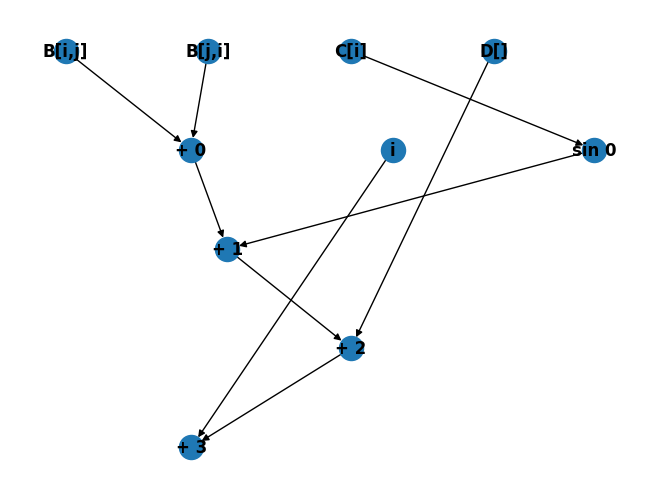

In [3]:
print(small_program.tensor_expressions[1].op_graph.nodes())
tc.viz.draw_expression_graph(small_program.tensor_expressions[1])

In [4]:

B = np.ones((10,10))
C = np.ones(10) + 10
expected = B + B.T + np.sin(C) + 100 + np.arange(10).reshape(-1,1)
result = small_program.execute({'B': B, 'C': C, 'D': 100}, shape_hints={'A': (10,10)})
print(expected)
print(result["A"])
np.all(result["A"] == expected)

[[101.00000979 101.00000979 101.00000979 101.00000979 101.00000979
  101.00000979 101.00000979 101.00000979 101.00000979 101.00000979]
 [102.00000979 102.00000979 102.00000979 102.00000979 102.00000979
  102.00000979 102.00000979 102.00000979 102.00000979 102.00000979]
 [103.00000979 103.00000979 103.00000979 103.00000979 103.00000979
  103.00000979 103.00000979 103.00000979 103.00000979 103.00000979]
 [104.00000979 104.00000979 104.00000979 104.00000979 104.00000979
  104.00000979 104.00000979 104.00000979 104.00000979 104.00000979]
 [105.00000979 105.00000979 105.00000979 105.00000979 105.00000979
  105.00000979 105.00000979 105.00000979 105.00000979 105.00000979]
 [106.00000979 106.00000979 106.00000979 106.00000979 106.00000979
  106.00000979 106.00000979 106.00000979 106.00000979 106.00000979]
 [107.00000979 107.00000979 107.00000979 107.00000979 107.00000979
  107.00000979 107.00000979 107.00000979 107.00000979 107.00000979]
 [108.00000979 108.00000979 108.00000979 108.00000979 1

np.True_

## Min reduction

In [5]:
min_red_program = tc.compile("""
Min[j] = 10000
Min[j] += (X[i,j] < Min[j]) * (X[i,j] - Min[j])
""")

X = np.random.randn(200,10)
expected = X.min(axis=0)
print(expected)

result = min_red_program.execute({'X': X}, shape_hints={'Min': (10,)})
print(result["Min"])
print(np.all(result["Min"] == expected))



[Tree(Token('RULE', 'tensorop'), ['X[i,j]']), 'Min[j]']
[Tree(Token('RULE', 'tensorop'), ['X[i,j]']), 'Min[j]']
[Tree(Token('RULE', 'tensorop'), ['< 0']), '- 0']
[-2.56324801 -2.68421459 -2.5379681  -2.33570916 -2.18367551 -2.48281272
 -2.50390233 -2.72294916 -3.28536613 -2.24506665]
[-2.56324801 -2.68421459 -2.5379681  -2.33570916 -2.18367551 -2.48281272
 -2.50390233 -2.72294916 -3.28536613 -2.24506665]
True


## KMeans Kernel

Reducing the classic way
Reducing the classic way
Reducing the classic way
Min:  [ 3.62624341  0.          7.16275805  0.58269411  6.01609074  2.98342349
  0.40835705  0.          1.47143093  0.          1.62060638  0.
  1.20027484 13.81014732  2.21471918  4.2837955   5.30898064  3.89037953
  3.45555983  0.        ]
expected_min:  [ 3.62624341  0.          7.16275805  0.58269411  6.01609074  2.98342349
  0.40835705  0.          1.47143093  0.          1.62060638  0.
  1.20027484 13.81014732  2.21471918  4.2837955   5.30898064  3.89037953
  3.45555983  0.        ]
expected_Labels:  [2 0 2 3 3 4 3 3 0 2 0 1 0 0 3 4 4 0 2 4]
[ True  True  True  True  True  True False  True False  True False  True
 False False  True  True  True False False  True]
Labels:  [2. 0. 2. 3. 3. 4. 3. 3. 0. 2. 0. 1. 0. 0. 3. 4. 4. 0. 2. 4.]
Dist ~= expected_Dist:  True
Min ~= expected_Min:  True
Labels ~= expected_Labels:  True
Count ~= expected_Count:  True
Update ~= expected_Update:  True
expected_Update: [[ 0.7

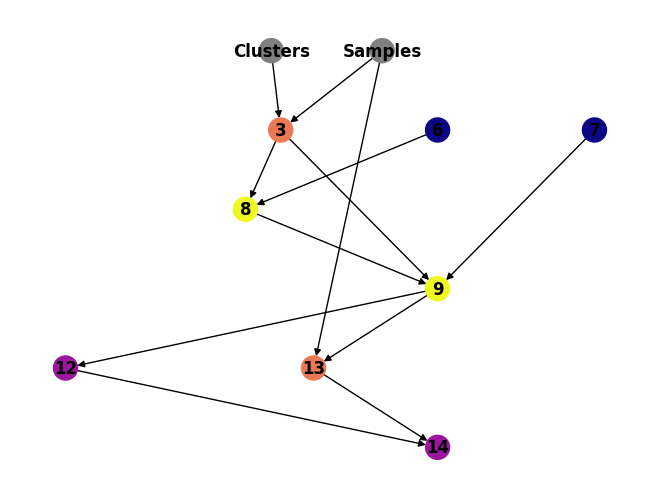

In [16]:
from scipy.spatial.distance import cdist
TOL = 1e-7

code = """
# Distance computation
Dist[j,k] += (Samples[j,l] - Clusters[k,l]) ^ 2

# Argmin
Min[j] = 1000
Labels[j] = -1
Min[j] += ( Dist[j,k] < Min[j] ) * ( Dist[j,k] - Min[j] )
Labels[j] += (Dist[j,k] == Min[j]) * (k - Labels[j])

# # Cluster update
Count[l] += (Labels[j] == l)
Update[l,k] += Samples[j,k] * (Labels[j] == l)
Update[l,k] = Update[l,k] / Count[l]
"""
kmeans_kernel = tc.compile(code)

n_samples = 20
sample_dim = 5
n_cluster = 5

Samples = np.random.randn(n_samples, sample_dim)
Clusters = Samples[np.random.randint(n_samples, size=n_cluster)]

# Compute expected labels
expected_Dist = cdist(Samples, Clusters, 'sqeuclidean')
expected_Min = np.min(expected_Dist, axis=1)
expected_Labels = expected_Dist.argmin(axis=1)

# Update cluster centers
expected_Count = np.zeros(n_cluster)
expected_Update = np.zeros((n_cluster, sample_dim))

for j in range(n_samples):
    l = expected_Labels[j]
    expected_Count[l] += 1
    expected_Update[l] += Samples[j]

expected_Update /= expected_Count.reshape(-1, 1)


outputs = kmeans_kernel.execute(inputs={
    'Samples': Samples,
    'Clusters': Clusters
}, shape_hints={
    'Dist': (n_samples, n_cluster),
    'Min': (n_samples,),
    'Labels': (n_samples,),
    'Count': (n_cluster,),
    'Update': (n_cluster, sample_dim)
})

print("Min: ", outputs['Min'])
print("expected_min: ", expected_Min)
print("expected_Labels: ", expected_Labels)
print(expected_Min == outputs['Min'])
print("Labels: ", outputs['Labels'])
print("Dist ~= expected_Dist: ", np.all(outputs['Dist'] == expected_Dist))
print("Min ~= expected_Min: ", np.allclose(outputs['Min'], expected_Min))
print("Labels ~= expected_Labels: ", np.all(outputs['Labels'] == expected_Labels))
print("Count ~= expected_Count: ", np.all(outputs['Count'] == expected_Count))
print("Update ~= expected_Update: ", np.allclose(outputs['Update'], expected_Update))
print(f"expected_Update: {expected_Update}")
print(f"Update: {outputs['Update']}")

draw_program_graph(kmeans_kernel, color_by="opcount")

Positioning nodes


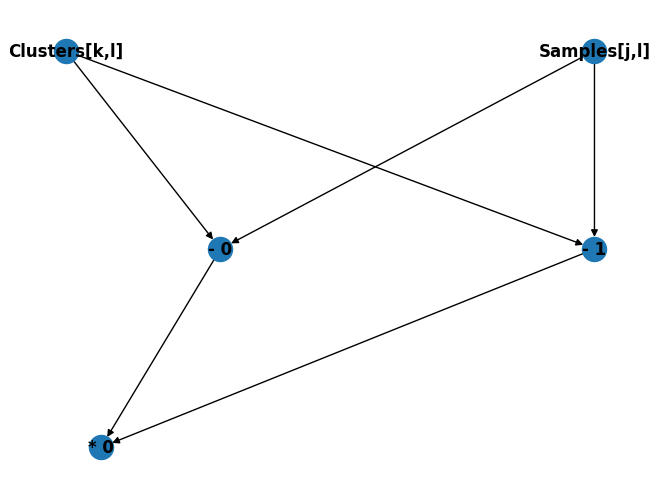

In [7]:
draw_expression_graph(kmeans_kernel.tensor_expressions[3])

## Conjugate Gradient

[Tree(Token('RULE', 'tensorop'), ['A[i,j]']), 'D_c[j]']
[Tree(Token('RULE', 'tensorop'), ['G_c[i]']), 'G_c[i]']
[Tree(Token('RULE', 'tensorop'), ['D_c[i]']), 'W_c[i]']
[Tree(Token('RULE', 'tensorop'), ['Gamma_c[]']), 'Theta_c[]']
[Tree(Token('RULE', 'tensorop'), ['Alpha_c[]']), 'D_c[i]']
[Tree(Token('RULE', 'tensorop'), ['X_c[i]']), '* 0']
[Tree(Token('RULE', 'tensorop'), ['Alpha_c[]']), 'W_c[i]']
[Tree(Token('RULE', 'tensorop'), ['G_c[i]']), '* 0']
[Tree(Token('RULE', 'tensorop'), ['G_n[i]']), 'G_n[i]']
[Tree(Token('RULE', 'tensorop'), ['Gamma_n[]']), 'Gamma_c[]']
[Tree(Token('RULE', 'tensorop'), ['Beta_n[]']), 'D_c[i]']
[Tree(Token('RULE', 'tensorop'), ['* 0']), 'G_n[i]']
Positioning nodes


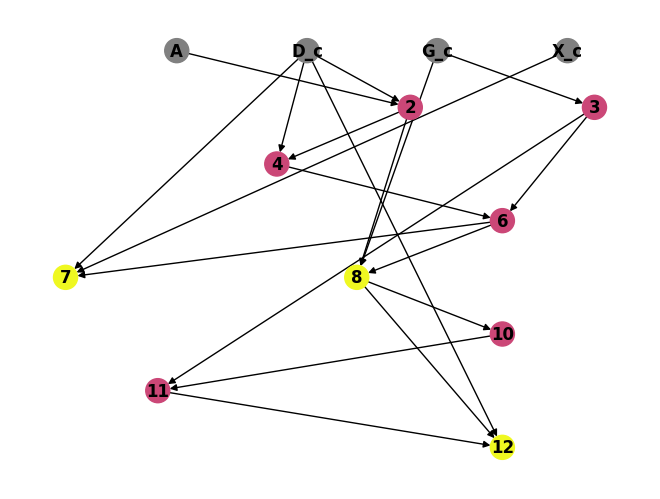

In [8]:
code = """
W_c[i] += A[i,j] * D_c[j]
Gamma_c += G_c[i] * G_c[i]
Theta_c += D_c[i] * W_c[i]

Alpha_c = Gamma_c / Theta_c
X_n[i] = X_c[i] + (Alpha_c * D_c[i])
G_n[i] = G_c[i] + (Alpha_c * W_c[i])

Gamma_n += G_n[i] * G_n[i]
Beta_n = Gamma_n / Gamma_c
Delta_n += (Beta_n * D_c[i]) - G_n[i]
"""
conjugate_gradient_kernel = tc.compile(code)

draw_program_graph(conjugate_gradient_kernel, color_by='opcount')


Positioning nodes


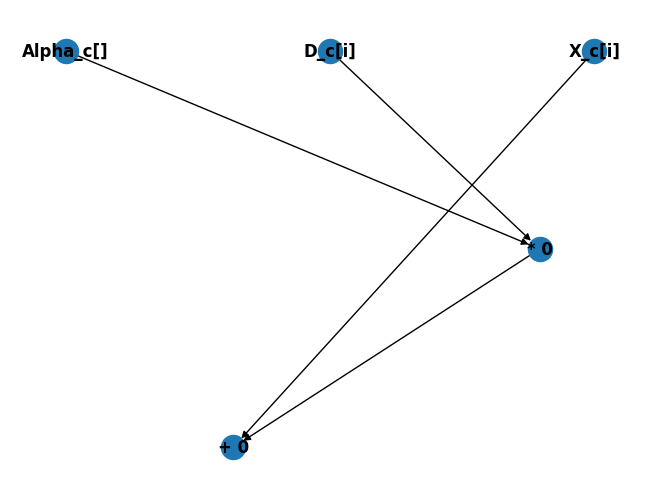

In [9]:
draw_expression_graph(conjugate_gradient_kernel.tensor_expressions[7])

## Transformer (Multi-Head Attention)

**Constants**

- B: Batch Size
- L: Sequence Lenght
- M: Embedding Size
- H: Number of Atte Heads
- E: Head Embedding Size (M / H)
- Sqe: sqrt(E)


**Inputs**

- X: Samples (B x L x M)
- W(q|k|v): Query/Key/Value Weight Matrix (H x M x E)
- Wz: Linear Layer (M x M)


Positioning nodes


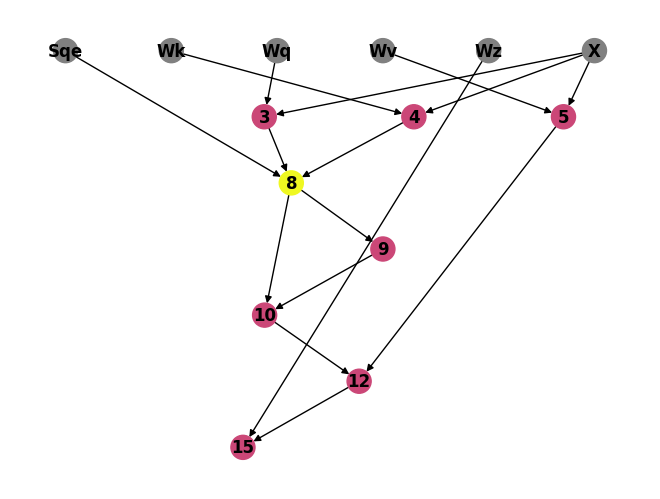

In [17]:
code = """
# Query, Key, Value
Q[i,j,k,l] += X[i,k,m] * Wq[j,m,l] # (B x H x L x E) 
K[i,j,k,l] += X[i,k,m] * Wk[j,m,l] # (B x H x L x E) 
V[i,j,k,l] += X[i,k,m] * Wv[j,m,l] # (B x H x L x E) 

# Attention
A[i,j,k,m] += (Q[i,j,k,l] * K[i,j,m,l]) / Sqe # (B x H x L x L)
Denom[i,j,k] += exp(A[i,j,k,m]) # (B x H x L)
Softmax[i,j,k,m] = A[i,j,k,m] / Denom[i,j,k] # (B x H x L x L)

Atte[i,j,(kl)] += Softmax[i,k,j,m] * V[i,k,m,l] # (B x L x M)

# Linear
Z[i,j,l] += Atte[i,j,k] * Wz[k, l] # (B x L x M)
"""
conjugate_gradient_kernel = tc.compile(code)

draw_program_graph(conjugate_gradient_kernel, color_by='opcount')
